# ASL Alphabet Classification

## Import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

2025-08-18 15:30:13.505750: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 15:30:13.506383: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 15:30:13.509395: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 15:30:13.518182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755505813.533448    4907 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755505813.53

In [2]:
ASL_TRAIN_DATA = '../DATA/asl/asl-landmark/train.csv'
ASL_TEST_DATA = '../DATA/asl/asl-landmark/test.csv'
ASL_KERAS_MODEL = '../model/asl_classifier/asl_classifier.keras'
ASL_TFLITE_MODEL = '../model/asl_classifier/asl_classifier.tflite'
ASL_LOGS =  '../model/asl_classifier/asl_logs'

## Load Data

In [3]:
HAND_LANDMARK = 21
DIMENSION = 2

Train Landmark Data

In [16]:
X_train_full = np.genfromtxt(ASL_TRAIN_DATA, delimiter=',', dtype='float32', usecols=list(range(1, (HAND_LANDMARK * DIMENSION) + 1)))
y_train_full = np.genfromtxt(ASL_TRAIN_DATA, delimiter=',', dtype='int32', usecols=(0))

In [17]:
X_train_full.shape, y_train_full.shape

((19600, 42), (19600,))

In [18]:
X_train_full[0]

array([ 0.        ,  0.        ,  0.3164557 , -0.16455697,  0.5316456 ,
       -0.48101267,  0.5316456 , -0.7848101 ,  0.4556962 , -1.        ,
        0.4050633 , -0.6075949 ,  0.34177214, -0.9113924 ,  0.30379745,
       -0.7848101 ,  0.30379745, -0.6455696 ,  0.17721519, -0.5822785 ,
        0.12658228, -0.8607595 ,  0.11392405, -0.5949367 ,  0.12658228,
       -0.39240506, -0.02531646, -0.5443038 , -0.07594936, -0.75949365,
       -0.05063291, -0.5063291 , -0.02531646, -0.3164557 , -0.21518987,
       -0.46835443, -0.24050634, -0.65822786, -0.20253165, -0.48101267,
       -0.16455697, -0.34177214], dtype=float32)

In [19]:
y_train_full[0]

0

In [21]:
X_test = np.genfromtxt(ASL_TEST_DATA, delimiter=',', dtype='float32', usecols=list(range(1, (HAND_LANDMARK * DIMENSION) + 1)))
y_test = np.genfromtxt(ASL_TEST_DATA, delimiter=',', dtype='int32', usecols=(0))

In [22]:
X_test.shape, y_test.shape

((765, 42), (765,))

In [24]:
X_test[0]

array([ 0.        ,  0.        ,  0.43548387, -0.06451613,  0.7258065 ,
       -0.41935483,  0.8548387 , -0.7580645 ,  1.        , -0.9677419 ,
        0.61290324, -0.7903226 ,  0.7258065 , -0.9354839 ,  0.6451613 ,
       -0.67741936,  0.58064514, -0.48387095,  0.37096775, -0.83870965,
        0.48387095, -0.9677419 ,  0.4516129 , -0.6451613 ,  0.4032258 ,
       -0.41935483,  0.14516129, -0.82258064,  0.24193548, -0.9354839 ,
        0.2580645 , -0.58064514,  0.22580644, -0.37096775, -0.08064516,
       -0.7580645 ,  0.03225806, -0.8064516 ,  0.06451613, -0.5645161 ,
        0.06451613, -0.4032258 ], dtype=float32)

In [23]:
y_test[0]

0

In [27]:
NUM_CLASSES = len(np.unique(y_train_full))
assert NUM_CLASSES == len(np.unique(y_test)), "Train and test's label not match"

In [28]:
NUM_CLASSES

28

## Split Data

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

In [30]:
X_train.shape

(17640, 42)

In [31]:
X_valid.shape

(1960, 42)

In [32]:
X_test.shape

(765, 42)

## Searching optimal learning rate

In [69]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [75]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(HAND_LANDMARK * 2,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
])

In [78]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,580 (60.86 KB)

 Trainable params: 15,580 (60.86 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [80]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4871 - loss: 1.5678 - val_accuracy: 0.6867 - val_loss: 0.7397


Text(0, 0.5, 'Loss')

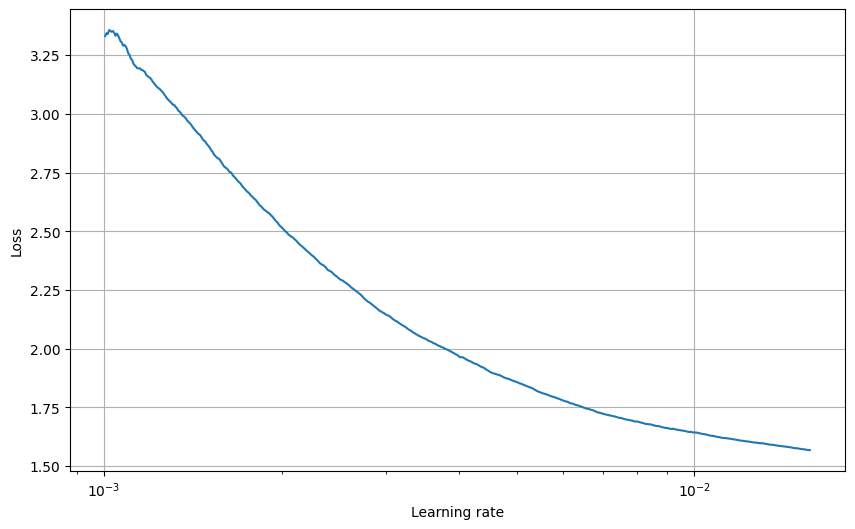

In [81]:
plt.figure(figsize=(10,6))
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
# plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
# plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

## Train Model

In [93]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(HAND_LANDMARK * 2,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
])

In [95]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,580 (60.86 KB)

 Trainable params: 15,580 (60.86 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [97]:
run_index = 1 # increment this at every run
run_logdir = Path(ASL_LOGS) / "run_{:03d}".format(run_index)
run_logdir

PosixPath('../model/asl_classifier/asl_logs/run_001')

In [98]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(ASL_KERAS_MODEL, monitor='val_accuracy', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [99]:
history = model.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/1000
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4399 - loss: 1.7184 - val_accuracy: 0.7658 - val_loss: 0.7595
Epoch 2/1000
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6457 - loss: 1.0188 - val_accuracy: 0.8474 - val_loss: 0.5583
Epoch 3/1000
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6905 - loss: 0.8964 - val_accuracy: 0.8592 - val_loss: 0.4868
Epoch 4/1000
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7109 - loss: 0.8139 - val_accuracy: 0.8893 - val_loss: 0.4460
Epoch 5/1000
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7367 - loss: 0.7632 - val_accuracy: 0.9082 - val_loss: 0.4078
Epoch 6/1000
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7549 - loss: 0.7187 - val_accuracy: 0.9179 - val_loss: 0.3789
Epoch 7/1000
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7671 - loss: 0.6850 - val_accuracy: 0.9179 - val_loss: 0.3691
Epoch 8/1000
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7741 - loss: 0.6562 - 

In [100]:
model = tf.keras.models.load_model(ASL_KERAS_MODEL) # rollback to best model
model.evaluate(X_test, y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8510 - loss: 0.5837  


[0.5837482810020447, 0.8509804010391235]

In [101]:
print(ASL_LOGS)
for path in sorted(Path(ASL_LOGS).glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

../model/asl_classifier/asl_logs
        run_001
          train
            events.out.tfevents.1755506932.LAPTOPTHNNDAT.4907.0.v2
            events.out.tfevents.1755508340.LAPTOPTHNNDAT.4907.2.v2
          validation
            events.out.tfevents.1755506934.LAPTOPTHNNDAT.4907.1.v2
            events.out.tfevents.1755508341.LAPTOPTHNNDAT.4907.3.v2


In [102]:
%load_ext tensorboard
%tensorboard --logdir=../model/asl_classifier/asl_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12978), started 0:22:28 ago. (Use '!kill 12978' to kill it.)

## Convert to TFLITE


In [103]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open(ASL_TFLITE_MODEL, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpl11nzrwg/assets


INFO:tensorflow:Assets written to: /tmp/tmpl11nzrwg/assets


Saved artifact at '/tmp/tmpl11nzrwg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)
Captures:
  137629358998624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137629361642608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137629359004432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137629360941264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137629360933872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137629357515424: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1755508406.843265    4907 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1755508406.843370    4907 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-08-18 16:13:26.843642: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpl11nzrwg
2025-08-18 16:13:26.844083: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-18 16:13:26.844094: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpl11nzrwg
2025-08-18 16:13:26.848216: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-18 16:13:26.869186: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpl11nzrwg
2025-08-18 16:13:26.875028: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 31356 microseconds.
